<font size="8"> <center> Quality control analysis of sequenced data </center> </font>

## Part 2 - Machine Learning

A naive CNV calling algorithm relies on unbiased sequencing to identify deletions and duplications from sequence coverage alone.  
A common bias in sequencing workflows is related to the GC content of the targeted regions, such that targeted regions at the  
extremities are over- or under-represented. To reduce turn-around-time and cost, samples that will ultimately be deemed unreliable  
 for CNV calling should be identified prior to the sequencing step.

Apply a machine learming model to predict sample with high probability to fail in QC metrics, and use this to flag "bad" samples.  

In [1]:
# libraries
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
# Import packages, functions, and classes for ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# setting some parameters
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 50, 'display.min_rows', 20)
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Python Version
from platform import python_version
print('The python version used in this Jupyter Notebook is:', python_version())

The python version used in this Jupyter Notebook is: 3.8.8


### Data

In [4]:
# find all the .txt files in the seq_qc_data folder
files_in_dir = []
for file in os.listdir("seq_qc_data"):
    if file.endswith(".txt"):
        files_in_dir.append(os.path.join("seq_qc_data", file))
 

In [5]:
# adding batch_iD column
list_of_files = []
for i in files_in_dir:
    file = pd.read_csv(i, delimiter='\s+', encoding='utf-8')
    basename = i.split("\\")[-1].split(".")[-2]
    file["batch_ID"] = basename
    list_of_files.append(file)

data = pd.concat(list_of_files)
data


,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID
0,11003983829384,blood,617,44.2660,565.1010,passed,passed,passed,SEQ_00001
1,11006875693894,blood,605,46.2890,540.5860,passed,passed,passed,SEQ_00001
2,11004739959773,blood,540,40.2700,575.0350,passed,passed,passed,SEQ_00001
3,11004651860473,blood,618,42.9250,560.4100,passed,passed,passed,SEQ_00001
4,55000241940904,saliva,518,39.4550,573.3510,passed,passed,passed,SEQ_00001
5,55001584273148,saliva,554,32.0080,591.3090,passed,passed,passed,SEQ_00001
6,55007383648670,saliva,577,49.8990,614.1260,passed,passed,passed,SEQ_00001
7,11007500545247,blood,679,42.2350,585.3280,passed,passed,passed,SEQ_00001
8,11009699566756,blood,494,38.1080,564.1710,passed,passed,passed,SEQ_00001
9,11004177857806,blood,543,42.6950,571.2540,passed,passed,passed,SEQ_00001


### Creating dummy variables

In [6]:
data.replace(["failed", "passed"], [0,1], inplace=True)

In [7]:
# Creating a new column call log2 fold change - log2FC=Log2(B)-Log2(A)
data["log2FC"] = np.log2(data.post_quant) - np.log2(data.pre_quant)
data

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,log2FC
0,11003983829384,blood,617,44.2660,565.1010,1,1,1,SEQ_00001,3.6742
1,11006875693894,blood,605,46.2890,540.5860,1,1,1,SEQ_00001,3.5458
2,11004739959773,blood,540,40.2700,575.0350,1,1,1,SEQ_00001,3.8359
3,11004651860473,blood,618,42.9250,560.4100,1,1,1,SEQ_00001,3.7066
4,55000241940904,saliva,518,39.4550,573.3510,1,1,1,SEQ_00001,3.8611
5,55001584273148,saliva,554,32.0080,591.3090,1,1,1,SEQ_00001,4.2074
6,55007383648670,saliva,577,49.8990,614.1260,1,1,1,SEQ_00001,3.6215
7,11007500545247,blood,679,42.2350,585.3280,1,1,1,SEQ_00001,3.7927
8,11009699566756,blood,494,38.1080,564.1710,1,1,1,SEQ_00001,3.8880
9,11004177857806,blood,543,42.6950,571.2540,1,1,1,SEQ_00001,3.7420


In [8]:
data.query('CNV_calling == 0')

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,log2FC
11,11007754041816,blood,523,41.0120,394.5350,1,0,1,SEQ_00001,3.2660
52,55009752612761,saliva,613,52.5440,426.1780,1,0,1,SEQ_00001,3.0199
71,11007279249728,blood,622,40.1280,506.4070,1,0,1,SEQ_00001,3.6576
80,55005158496132,saliva,507,52.9140,460.9690,1,0,1,SEQ_00001,3.1229
7,55000685907796,saliva,457,1.3590,184.1100,0,0,0,SEQ_00002,7.0819
9,11005235707618,blood,577,52.3000,200.8350,0,0,0,SEQ_00002,1.9411
34,55006856012338,saliva,560,33.2560,521.7560,1,0,1,SEQ_00003,3.9717
54,11003400082912,blood,500,42.1640,480.7410,1,0,1,SEQ_00003,3.5112
60,11001971231469,blood,532,49.2960,398.4610,1,0,1,SEQ_00003,3.0149
65,55003827817579,saliva,422,5.9820,110.5310,0,0,0,SEQ_00003,4.2077


In [10]:
# Find max and min ratio
print(min(data.log2FC))
print(max(data.log2FC))

-3.6226619675056013
12.688905930612712


In [11]:
# Finding the maximun and mininum ratio to pass in CNV_calling
print(min(data.query('CNV_calling == 1').log2FC))
print(max(data.query('CNV_calling == 1').log2FC))

2.617248885684406
4.834816158622272


In [12]:
# Finding the maximun and mininum ratio to fail in CNV_calling
print(min(data.query('CNV_calling == 0').log2FC))
print(max(data.query('CNV_calling == 0').log2FC))

-3.6226619675056013
12.688905930612712


## Logistic Regression

In [14]:
# Step 1: Get data
feature_cols = ["frag_size", "pre_quant", "post_quant", "log2FC"]
X = data[feature_cols]
y = data.CNV_calling

In [15]:
# # Step 2: split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [16]:
# normalization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [17]:
# Step 3: Create a model and train it
model = LogisticRegression(solver='liblinear', C=10e10, random_state=0, max_iter = 10000)
model.fit(x_train, y_train)

LogisticRegression(C=100000000000.0, max_iter=10000, random_state=0,
                   solver='liblinear')

In [18]:
# Step 4: Evaluate the model
x_test = scaler.transform(x_test)
p_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)

score_Train = model.score(x_train, y_train)

score_Test = model.score(x_test, y_test)

report = classification_report(y_test, y_pred)

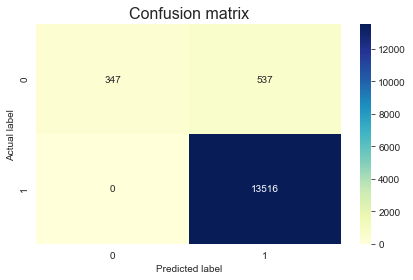

In [19]:
# Step 5: Visualization
conf_m = confusion_matrix(y_test, y_pred)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_m), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [20]:
# Step 6: report
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.39      0.56       884
           1       0.96      1.00      0.98     13516

    accuracy                           0.96     14400
   macro avg       0.98      0.70      0.77     14400
weighted avg       0.96      0.96      0.95     14400



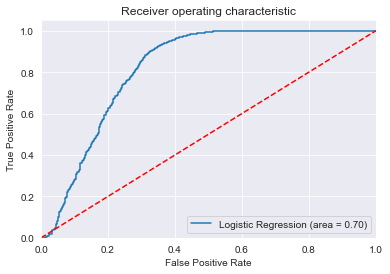

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Making predictions

In [22]:
# preparing data to prediction - normalization
scaler = StandardScaler()
var = scaler.fit_transform(X)

data['prediction'] = pd.Series(model.predict(var), index=X.index)
data

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,log2FC,prediction
0,11003983829384,blood,617,44.2660,565.1010,1,1,1,SEQ_00001,3.6742,1
1,11006875693894,blood,605,46.2890,540.5860,1,1,1,SEQ_00001,3.5458,1
2,11004739959773,blood,540,40.2700,575.0350,1,1,1,SEQ_00001,3.8359,1
3,11004651860473,blood,618,42.9250,560.4100,1,1,1,SEQ_00001,3.7066,1
4,55000241940904,saliva,518,39.4550,573.3510,1,1,1,SEQ_00001,3.8611,1
5,55001584273148,saliva,554,32.0080,591.3090,1,1,1,SEQ_00001,4.2074,1
6,55007383648670,saliva,577,49.8990,614.1260,1,1,1,SEQ_00001,3.6215,1
7,11007500545247,blood,679,42.2350,585.3280,1,1,1,SEQ_00001,3.7927,1
8,11009699566756,blood,494,38.1080,564.1710,1,1,1,SEQ_00001,3.8880,1
9,11004177857806,blood,543,42.6950,571.2540,1,1,1,SEQ_00001,3.7420,1


In [23]:
len(data.query('CNV_calling == 0 and prediction==0'))

730

In [24]:
# Finding true falses
data.query('CNV_calling == 1 and prediction==0')

,barcode,sample_type,frag_size,pre_quant,post_quant,coverage,CNV_calling,passed_well,batch_ID,log2FC,prediction
39,11004081700193,blood,493,54.8770,356.2740,1,1,1,SEQ_00296,2.6987,0


## Random Forest 

In [28]:
from sklearn.ensemble import RandomForestClassifier
modelo_v2 = RandomForestClassifier(random_state = 0)
modelo_v2.fit(x_train, y_train.ravel())

RandomForestClassifier(random_state=0)

In [35]:
# Training the model
rf_predict_train = modelo_v2.predict(x_train)
print(classification_report(y_train, rf_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       913
           1       1.00      1.00      1.00     13487

    accuracy                           1.00     14400
   macro avg       1.00      1.00      1.00     14400
weighted avg       1.00      1.00      1.00     14400



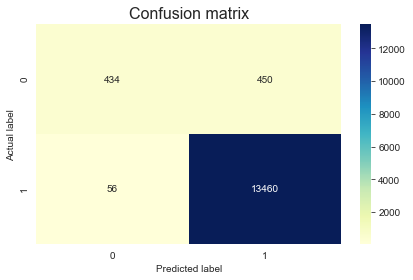

In [43]:
# Step 5: Visualization
conf_m = confusion_matrix(y_test, rf_predict_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_m), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [44]:
# report
print("Classification Report")
print(classification_report(y_test, rf_predict_test, labels = [0, 1]))

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.49      0.63       884
           1       0.97      1.00      0.98     13516

    accuracy                           0.96     14400
   macro avg       0.93      0.74      0.81     14400
weighted avg       0.96      0.96      0.96     14400



## Naive Bayes

In [25]:
# Step 3: Create a model and train it
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(x_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(x_test)

score_Train = model.score(x_train, y_train)

score_Test = model.score(x_test, y_test)

conf_m = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

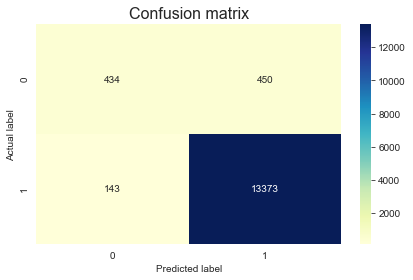

In [26]:
# Step 5: Visualization
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_m), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [27]:
# Step 6: report
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.49      0.59       884
           1       0.97      0.99      0.98     13516

    accuracy                           0.96     14400
   macro avg       0.86      0.74      0.79     14400
weighted avg       0.95      0.96      0.95     14400

